In [201]:
import numpy as np
from scipy.optimize import minimize

from sklearn.model_selection import train_test_split

features = np.load('features.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True) * 2 - 1
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)



batch = np.size(y_train)
z = 5
a = 15


CNN_out = np.random.randn(batch, a, 1) 

G = np.random.randn(z, a)
g = np.matmul(G, CNN_out)
W = np.random.randn(1, z)
y = np.matmul(W, g)


def vec2simplex(vecX, l=1):
  m = vecX.size
 
  vecS = np.sort(vecX)[::-1]
  vecC = np.cumsum(vecS) - 1
  vecH = vecS - vecC / (np.arange(m) + 1)
 
  r = np.max(np.where(vecH>0)[0])
  t = vecC[r] / (r+1)
 
  return np.maximum(0, vecX - t)



def fun(x, y_gt): # very simple loss function 
    if(isinstance(x, (np.ndarray))):
        #CNN = np.reshape(x[(z*a + z):], (batch, a, 1))
        G_ = np.reshape(x[:z*a], (z, a))
        for i in range(np.shape(G_)[0]):
            G_[i, :] = np.array(vec2simplex(G_[i, :]))
        W_ = x[z*a:z*a+z]#np.reshape(x[z*a:], z)
        g = np.matmul(G_, CNN_out)
        y = np.matmul(W_, g)
        y_pred = np.tanh(y)
        # sum of square loss 
        loss = np.sum((y_pred - y_gt)**2)
    else: 
        loss = np.Infinity
    print(loss)
    return loss



x0 = np.concatenate((np.reshape(G, z*a), np.reshape(W, z)))
fun(x0, y_train)


    


92.58339160864844


92.58339160864844

In [202]:
print(fun(x0, y_train))

x_fin = minimize(fun, x0, y_train, method='Nelder-Mead')





92.58339160864844
92.58339160864844
92.58339160864844
92.58330184961859
92.58420408543729
92.58502321617786
92.6224455846524
92.58396924222009
92.58360315201843
92.58345565404171
92.58282592337399
92.56415355660727
92.58358536425969
92.58583890118068
92.58471641577981
92.58260973714533
92.58551134712509
92.5816962394688
92.58358348423259
92.58299162981999
92.58245449453428
92.58340039555041
92.58314545735749
92.58338576011684
92.59126211042764
92.58389513055899
92.58364808318886
92.58339732637077
92.58191971322358
92.48973327046966
92.61841109556646
92.58213428656778
92.5846357574439
92.5607773222462
92.5828671695669
92.58249037316757
92.58315393938815
92.58297509087055
92.58314363870625
92.58321133134798
92.59278239394116
92.58332767669846
92.58315175182767
92.58211520191719
92.58263155676332
92.58360045801925
92.58226577200085
92.58402057171507
92.5834042467187
92.58330342524783
92.58321191621035
92.58337307293178
92.58332963942738
92.58337057344136
92.58298983427662
92.5834573654506

88.63280691493212
88.61375624717081
88.05536774629932
88.60465901996395
88.59275176361339
88.577174449812
88.5642448875761
88.54746860654677
88.53164498508471
88.51671591987646
88.49757813640625
88.48089690489282
88.46154360709072
88.43887252528835
88.41823843629564
88.39484090787101
88.36953650533263
88.34911633576242
88.32044273692286
88.31209195116901
88.29723580777934
88.26888666322616
88.25620664085996
88.24710808495489
88.26194628618931
88.21116643308113
88.21003447795377
88.19006726524317
88.16850139177664
88.15626931054466
88.12879693977746
88.12899942003963
88.10958152474157
88.12978447364047
88.10156280950072
88.08817252745797
88.06735002079593
88.05739371324165
88.04183187549226
87.44212752326378
88.00618312238136
87.99155067962451
87.97680351180527
87.95097869574496
87.96148393600619
87.94799412114865
87.935068150559
87.92222661927303
87.90941481361776
87.89709027216361
87.84979138914413
87.8568331522116
87.84335897609668
87.83017968151044
87.79496853388505
87.7859631556948

78.72183377959081
78.69902546989317
78.67951589414925
78.64310841974996
78.60301609516151
78.55862729649822
78.5272632888521
78.49521673535693
78.46309842901094
78.42545893292143
78.41583374607823
78.39961729152823
78.34308658392335
78.31028090087389
78.27779897516238
78.24438833905994
78.21282970834986
78.18273414875601
78.13711422713209
78.09750941837297
78.09646410189188
78.06839432214625
78.04137092086043
78.0146462412995
77.97594042582769
77.95735915854512
77.93333414903931
77.90845852267972
77.88552560841964
77.86145753667714
77.83857459512826
77.81643976811944
77.79234644048809
77.7694499088895
76.69431711734552
77.71738894471918
77.68921316841586
77.65322179779525
77.65189797510858
77.61614759950474
77.57842437485066
77.53475143037922
77.54814555998777
77.55764466636363
77.4657507819797
77.42234558570435
77.40361853789786
77.38126988605389
77.34070802933431
77.31438915417235
77.29504762258078
77.2618623065509
77.21614666304863
77.20176514192526
77.14696822965604
77.129270282896

68.1884827757437
68.24489594171719
68.45552241619204
68.1592997774805
68.27992259621415
68.17784907716879
68.1944124107477
68.16450569783625
68.37022403123783
68.24778527438208
68.46661296812809
68.31298334207268
68.14872447939491
68.15844906262954
68.43581565650868
68.12672881897777
68.2142000896884
68.35913307657736
68.12567469414019
68.40187528029378
68.19192258516924
68.18058511677714
68.09054147033677
67.89984629988678
68.30324104197582
68.32141693554293
68.08695792851574
68.17416514681896
68.13448604785792
68.15102622290212
68.40501540609455
68.10435752073487
68.07649947991787
68.18215628193785
68.10684744166348
68.04493743611856
68.36250203933335
68.04597798773456
68.13203941117257
68.02666713914424
68.03416295092028
68.09344412371074
68.1532287149966
68.30070317382787
68.12458226422797
68.00307328438579
68.05251620687116
67.99211902569579
68.10887107012303
68.02093732937821
68.33017106955926
68.26824218075343
68.02384101843523
68.07666821132803
67.99956662779489
68.083233591873

65.4015957248911
65.50143073862706
65.43143280529328
65.43931880349736
65.52852440512112
65.33550247415734
65.41710649743987
65.53658425135922
65.4018486537411
65.35150820382634
65.42718419888844
65.42630801648353
65.50807213397141
65.47434337987008
65.51044385988143
65.37391860128331
65.41038694937694
65.35872591215798
65.46537641297789
65.36403911492705
65.32829004057236
65.33647813916377
65.37882720780051
65.47454069035184
65.3378464183631
65.48862183149332
65.32639768201018
65.33153615621075
65.48410885912666
65.37162765778282
65.52868264350505
65.43080191976016
65.36902018077619
65.37238951640585
65.30264552666938
65.24745502240881
65.32446613610888
65.30183467221066
65.28032684178964
65.41860373566271
65.35980052300701
65.50621368333348
65.50538833665057
65.49753814164357
65.52072183187111
65.40952872792643
65.28695015678713
65.30721942284141
65.27228980222212
65.4117833211436
65.43654682802519
65.48653662540322
65.28277776686645
65.26236002715086
65.31262535139564
65.41485375366

64.58404826465983
64.5701075240825
64.66560896012616
64.62201182035656
64.65676234801325
64.58284314887608
64.59495137509346
64.65341004655427
64.58718449121521
64.63982627403702
64.55218135990225
64.45857294054355
64.5396732205423
64.66197458406084
64.54640878883954
64.55533817061436
64.6220048081214
64.60204197061537
64.67500278659067
64.5483671721913
64.53392327969928
64.54203075627493
64.5278063137665
64.60173415312036
64.66192061712455
64.5172963187409
64.53341880823702
64.62840653928868
64.5223107820866
64.55735346856497
64.5014246729957
64.52598530415145
64.5226907288448
64.51422278012689
64.5104722802497
64.52733405858756
64.5522475295518
64.58198862186279
64.50019942790985
64.56337666917395
64.46976042674457
64.46922644522847
64.50670855385069
64.585451256471
64.48663889343875
64.50213909446126
64.46130495562578
64.46301231030829
64.53095391419151
64.54595235549164
64.55440935533646
64.53361913621485
64.44607350410143
64.34614352948387
64.45320235757893
64.44330648899428
64.49

62.98669139764853
62.806654019101494
62.99632347742284
63.02986820427063
63.18043803436843
62.9543758079879
62.977747814801674
62.94033337795379
62.96514895178032
63.15302323334813
62.9947492130273
63.104759615387266
62.92839988790405
62.98276669629166
62.972488519404024
62.92775958310312
63.00119239380488
62.95692946997319
62.983738319357904
62.950530510824585
62.984266695823315
62.923713685704215
63.078937535786416
62.960756961343314
62.97145024006809
62.9169782993762
62.87760406247151
62.892380791997475
63.01526486465717
62.91697128143449
63.06212331574587
62.98396301599274
62.85479307413998
62.84343440721955
62.9020643290715
62.85294920327568
62.84600590304162
62.81707345448595
62.89056388599374
62.81700936043193
62.829584377504126
62.794261234579096
62.59180258662553
62.84912528415066
62.91481799446448
62.813246347188745
62.794677862618606
62.98473190722896
62.76565624756726
62.81011410112632
62.798888819001114
62.761691708543104
62.72959652374784
62.822889295440774
62.88433430850

60.38507221645857
60.3045773718047
60.410003953941406
60.31309398516751
60.40337138515421
60.338037882945024
60.51453403427305
60.48768714428008
60.397608753032785
60.32718623372671
60.53220775255388
60.291950720210444
60.307320997233695
60.32348304901186
60.270001941784244
60.35080570315828
60.25453358167729
60.34030008354672
60.24376480357357
60.0670557663357
60.37680830188622
60.37032952521472
60.26212686502446
60.28574908101768
60.24125360344124
60.31434877930228
60.21100496861507
60.262016328672004
60.26807398616674
60.29122886296037
60.22074571345329
60.19963140729796
60.14368532203089
60.15765374962909
60.13230936029127
60.16188248000223
60.21635946248547
60.47028546372782
60.132132272726594
60.14186616629751
60.11865667951535
60.31074514913279
60.242737603464036
60.11060082722589
60.18097569155464
60.23514775301818
60.19441593433495
60.17625864646421
60.09541612504161
60.123024370855845
60.10456463722204
60.10197176347496
60.1465916991629
60.3222515056031
60.19074430259355
60.1

59.275243904753665
59.314998206998816
59.34315904546272
59.29149396768542
59.31495140846657
59.27307054205445
59.314394154017194
59.27717260604117
59.26559009883922
59.29113559291678
59.25565354981874
59.3307362747789
59.28261186866491
59.3314687886811
59.28720130664663
59.274872428824146
59.27484029803365
59.27364429829556
59.24829013513189
59.247763977767235
59.23413367960122
59.27670117979436
59.26532263528962
59.215666225687336
59.17420743740548
59.267681777702435
59.22273955755434
59.2166379309184
59.26284361248266
59.30450933264843
59.24227615264957
59.30226999228611
59.21871181748585
59.311121568170655
59.30024975799597
59.21633138754622
59.22610997369738
59.300531761386495
59.23163889685922
59.26019176139704
59.25024181576677
59.31948958808558
59.266383076808104
59.205868303577475
59.202006006270196
59.23554136772036
59.301495987226936
59.20312661945761
59.240570558629535
59.20663050204698
59.211788482143746
59.23861264764844
59.28712055544995
59.278700437433784
59.246454302332

59.014716488929785
59.014392006896074
59.02346845981077
59.03534772489808
59.032135386473925
59.03300752322145
59.034604365893806
59.017176961966086
59.02682826715574
59.01360818800663
59.03312619586249
59.03644244096697
59.022067297194134
59.007565184246616
59.004802270685
59.03340233174905
59.03410154285071
59.02086169096852
59.02748220028398
59.01390943137117
59.02271780776778
59.02977323421049
59.0308705250336
59.03235836733363
59.010218163456614
59.02952740316822
59.006868578348886
59.02402101948388
59.02234871547021
59.028538404272375
59.00737844507337
59.02844101519118
59.03013591822133
59.03215698157031
59.03229163694905
59.02944861688484
59.034504535459526
59.01921856315363
59.02658596346909
59.027556739382966
59.01840581801139
59.03359764925399
59.019080927606204
59.02415355269757
59.03495234843237
59.018744012029295
59.02488239121
59.02475050652191
59.00684149171843
59.024368112324254
59.011342711982934
59.01245802356972
59.005544837685335
59.00440471555413
59.00478675495993

58.88248912635311
58.88638398949556
58.86814537279666
58.86403037317343
58.889107431998895
58.88973263750725
58.87954987365621
58.880773872896846
58.89015845880295
58.87932654815117
58.88734736498201
58.884136074184966
58.885163398485034
58.87685941977796
58.868465956888635
58.867394008375165
58.87954135587453
58.86962783246369
58.89054389228871
58.87801450577315
58.88548895944204
58.882491107411305
58.87812827443023
58.87827268625362
58.88735043548491
58.8778853874603
58.87862974023561
58.87050293568209
58.88570719043399
58.88386265909537
58.87428789937327
58.88366097456991
58.884154746120224
58.86677359111287
58.885727798100795
58.876906185008075
58.87399171171687
58.87423308798442
58.8836838167325
58.867691463555964
58.8849917604403
58.86636476957815
58.88285084844383
58.874938358935864
58.88496765713137
58.879160774083175
58.88475104463226
58.87292200013861
58.86595797270082
58.88360779316278
58.879595541665694
58.87059417361993
58.87759358424413
58.882656492362614
58.8803314997533

58.78904105410248
58.78385712032021
58.78441839828392
58.801026746268896
58.79813400152535
58.78494164812714
58.780090321513086
58.797809108185085
58.7805282123895
58.788929141124456
58.78155656094079
58.79256632830183
58.78547093521468
58.77550457228472
58.762221349359734
58.78902254225985
58.79568341535555
58.78131858893639
58.77765854614675
58.78276706008314
58.7896728734796
58.78208994474771
58.780497123228734
58.78413103787169
58.774415450769744
58.7857166889867
58.78298452360457
58.79137810822701
58.778073102878075
58.78000951177085
58.77304897237395
58.783017391622764
58.77699143538262
58.768523814951486
58.77113156064518
58.76996390655214
58.78615407794452
58.78146327422482
58.78388415874795
58.775110863341716
58.78366882611223
58.781183941113845
58.77385707346006
58.77444432387388
58.76982246825928
58.77239473884228
58.774649470698805
58.771640386401195
58.76574216205399
58.78444999176071
58.76737353827842
58.77932150267267
58.76428404098228
58.75902200275247
58.74233920326146

58.32675347576899
58.33464651143454
58.32582471141748
58.35435370082729
58.3357766998388
58.34686761609893
58.322490188243926
58.340846994521485
58.32327674116074
58.338655613469385
58.322586343441095
58.32482796421255
58.32502072087851
58.33204723994421
58.31661643735474
58.327511053116915
58.319166168456135
58.323051778709974
58.313577632785986
58.29598086035995
58.31736239320844
58.31693295946415
58.32553671879519
58.321905232721946
58.31738566944149
58.3080537759053
58.313918386654855
58.30642672573346
58.305751572783244
58.33687271419157
58.314893775174205
58.32201493758979
58.3193257733495
58.31359174618554
58.3031269258564
58.297890647089524
58.31352720729974
58.30295109997254
58.29989453144046
58.31371455381238
58.29624256138931
58.31325919365915
58.319322261161346
58.306746104837174
58.29926650347563
58.32668918707977
58.29591859951753
58.283948782995104
58.28956384254687
58.30534999302033
58.288294134949865
58.29607058440519
58.286193580835715
58.2891530375725
58.286832381998

58.054946914673685
58.0887266741603
58.07057028176001
58.06438657726386
58.072041259765406
58.08110628938872
58.079154427138704
58.073296810539496
58.062263710601776
58.06391038801485
58.063156031570244
58.05566187906424
58.05855609666791
58.08798764406755
58.05732473152797
58.08821973153529
58.071946407922816
58.061663672194555
58.05651338214434
58.056134211979035
58.05969666478676
58.049364231239245
58.039940788912524
58.06373927985736
58.07389626826523
58.067925640850945
58.06111272640007
58.05709923681563
58.049457567145836
58.06580798990721
58.04694873593803
58.06073122871033
58.0741988597048
58.057948531857846
58.0584278417126
58.064974305134996
58.0603968370804
58.046292734340405
58.058315967390705
58.051721046341285
58.07241466587027
58.04595949557739
58.05977678245348
58.04598970717566
58.050000166318085
58.045767056898285
58.06651628938417
58.06223510190931
58.04919905108788
58.04767548100735
58.047760438486186
58.04455277067672
58.05182011244353
58.04800069146053
58.04159657

57.88056466328868
57.86890330575205
57.87202625929179
57.86511577933757
57.86232420594035
57.877041517217805
57.88209350995237
57.874634370378445
57.8766720911964
57.89846537585061
57.863522697944326
57.86196093891047
57.85612938102754
57.873947561443266
57.89959848409119
57.86536227264697
57.89937470484552
57.859536483266375
57.8718584618951
57.898239250461735
57.870730827716194
57.879917275234156
57.866706554772854
57.89126426872061
57.88098369364031
57.89875308129361
57.879730415638306
57.87384640308261
57.879960539773414
57.87539133754106
57.872556949444764
57.859827749646435
57.86757869453412
57.877104516971286
57.86646881812721
57.86018679634618
57.886098414829604
57.86172297281006
57.8597603038541
57.864534385316304
57.876081523198366
57.87532523350854
57.8595616722893
57.86205826072199
57.856381105807756
57.85684543373545
57.862393179736486
57.874482268477735
57.88717706548227
57.85715140582025
57.860783766567536
57.86203706317091
57.85846593957196
57.85776385907647
57.86285116

57.77826242298715
57.77793944513205
57.774206865668006
57.76865238932791
57.77945729986908
57.77468208176435
57.76842413451462
57.77751463010594
57.77568716770412
57.768847596734595
57.776478363660836
57.76929531123435
57.778628460177586
57.778162169054525
57.77888267990494
57.77086228770701
57.765079944757176
57.775127327346354
57.778417720782585
57.77663116299761
57.77547872255935
57.78347672271974
57.76873371574842
57.77702490943896
57.77316326694742
57.77637187031128
57.78020473287984
57.76895074407855
57.77768890484214
57.77914494607843
57.769073480657546
57.77896525002252
57.76906905100554
57.77732383843712
57.77791911599233
57.77898155566963
57.76890273395618
57.7761707800542
57.77835475391781
57.768938611436795
57.77791039715606
57.7688532192342
57.77343114174203
57.778677388239856
57.76873610337101
57.772992336115486
57.777551363002104
57.76873586417078
57.77823966802882
57.7686295835355
57.7734112406024
57.77807733910418
57.76860180052368
57.77728245571656
57.76870937990655
5

57.76201288954187
57.76028771782636
57.7592599415003
57.762715956208375
57.760635719242515
57.76157408108201
57.76086817264004
57.76104470072124
57.75912004247736
57.760051880784324
57.761938733647824
57.75961050090269
57.761484037943305
57.760086433807466
57.762526783522866
57.7605200993416
57.7617342265988
57.759013249242
57.76002835552305
57.758573073753084
57.759204488910264
57.7584909926155
57.758651199401214
57.75864215413158
57.75839408781078
57.75859908944537
57.761214072870196
57.76162192872654
57.760771564107934
57.75822713118694
57.75872055911728
57.75787493917318
57.757801566978486
57.76206716393887
57.76074535710905
57.75807959615466
57.761195358799256
57.759719242156514
57.75813002662114
57.76187732054411
57.760544378970245
57.757398042551074
57.756585872250305
57.7596787477127
57.75752107851583
57.76014909706787
57.75964954482431
57.76004947760707
57.75907542192373
57.76146789230317
57.75916965198757
57.759981442958065
57.75825231197658
57.758672923963296
57.760048588201

57.69133904945503
57.69046783951482
57.691198315573686
57.69271032208838
57.69091052168767
57.691658394140326
57.69162890587861
57.69126232548734
57.69382887457213
57.69111826037756
57.69250261198471
57.691768299514514
57.69605146183574
57.692664477310615
57.69245149376867
57.69157607939392
57.693194121241035
57.69388454551118
57.69294957387084
57.689310391038376
57.690041302526
57.69075524259977
57.69280394262034
57.697680985329605
57.693115469678425
57.68970606477708
57.69222388418385
57.69082718382968
57.6925301319209
57.69178010878467
57.69037146509074
57.69149712022904
57.693452209373085
57.69097019751634
57.69371241759396
57.6909023592597
57.69161484374543
57.69443515108281
57.69284507296007
57.68933017736334
57.69017788322337
57.69524142854574
57.69144594650055
57.68935274876024
57.689790598546516
57.69038145085104
57.69160710238216
57.691648186288155
57.692060835683414
57.69008439881003
57.68990519821449
57.69595022749655
57.691336078551494
57.68992093739222
57.68979353083327
5

57.6839298186362
57.684229306662665
57.683755194436124
57.68634047284773
57.68496478818445
57.68526075824676
57.6842839310146
57.68453097754638
57.68406169182009
57.684296744335356
57.68392274427226
57.68556324159548
57.68346726997059
57.68345028988792
57.68490437306273
57.68437886231801
57.684273029654385
57.68446278832294
57.68486499719312
57.684352719154674
57.68441147999087
57.68400971149577
57.684868536821746
57.68493669020068
57.68496121655886
57.68504500201158
57.68396831074483
57.68444191745741
57.68361965696633
57.68370078574495
57.68457485353447
57.68465374796923
57.68420696285097
57.68448548264553
57.68429932558399
57.68491838011104
57.68326781475786
57.683681072528586
57.68398158759094
57.68419585037578
57.68452619558224
57.68519327350095
57.68301794757548
57.68305918536167
57.68312811452133
57.683111253226
57.68400514467788
57.68323676867747
57.68324502275106
57.68261661497298
57.682550951341376
57.684143277877304
57.6837883302539
57.6829134869917
57.68310741014358
57.6842

57.66360498072984
57.66281353378398
57.665390873674674
57.6617064871976
57.66228281705661
57.66140493773526
57.66368256168196
57.665275640441074
57.66267300830695
57.66328295636007
57.66303889151642
57.661657955465955
57.662400409191996
57.66312925047983
57.66498999188921
57.66073073172898
57.658164490144294
57.66144215898709
57.66213853621801
57.66044690338427
57.660418741106966
57.660811805882545
57.66253776752448
57.660940407646216
57.663079515822005
57.66116027888061
57.66250128170367
57.660558984618916
57.660291516783
57.663268550474655
57.66105315828442
57.66090722730419
57.660994700757676
57.65991813159846
57.661947948611044
57.659141298864306
57.659626995219895
57.65979393225223
57.661131491472446
57.66047645888859
57.66060258417483
57.65878510749999
57.65840998593266
57.65910596418714
57.659188595454566
57.658730660708244
57.65865950415064
57.660039130137925
57.660201850924146
57.65997067728726
57.658557167072004
57.65852436410796
57.659632632869
57.65715192589009
57.654650974

57.630322376373826
57.63065031606816
57.63107836579678
57.63003977484399
57.6311105854562
57.62943031117073
57.63090538156418
57.63138940291223
57.63075516393028
57.63166938538062
57.63178316217679
57.630203837470496
57.630999084299475
57.6317251295023
57.63018639631327
57.63120973055506
57.629872632894326
57.631758990797735
57.63012134902774
57.63034341406557
57.63085289414355
57.631037309295266
57.63114015819329
57.6310293937032
57.632117294107125
57.63001580903239
57.63085895617831
57.630272466728435
57.63068286377112
57.63170160627759
57.6300066071198
57.63078248383596
57.63133773049912
57.63062601417814
57.631324817091226
57.630555410693695
57.63035301636899
57.630167834279035
57.63093316271225
57.631355665902156
57.6299670825615
57.63080906534894
57.630279341004794
57.63138967000925
57.629896865097415
57.63044906338725
57.628951713872056
57.630286738024324
57.630131485135564
57.63119643855373
57.62904879967949
57.63118107792502
57.63118840055313
57.62985695703242
57.6312039995711

57.62676088240538
57.62746915198804
57.62697345586857
57.62712225803794
57.627732985809516
57.62752461771226
57.62711219972789
57.62720861688086
57.6272277882118
57.627705620722566
57.62712361223764
57.627564528635936
57.6271289489923
57.62723083547569
57.62744720596145
57.626925469873086
57.62697978725723
57.627446556349604
57.62740911588392
57.62684738579357
57.62720488182979
57.62739432074686
57.62726665364178
57.626803448365855
57.62758600534196
57.627716222093085
57.62720282198141
57.62711252866202
57.62772352041965
57.627147758099085
57.62709260695735
57.6276307379051
57.62657505571144
57.626940656962155
57.62688267174421
57.62735278142716
57.627075544946415
57.627273865881385
57.62750252516162
57.627024831063764
57.6270462130241
57.626405257922
57.6262201342413
57.62667971317016
57.62723183881184
57.62700880944321
57.62680875949979
57.62752947062413
57.62716987851889
57.62664841430358
57.62720008357349
57.626834627936255
57.62739294176356
57.62708724442486
57.62704295407326
57.6

57.621818898986675
57.622007753206
57.62197356468061
57.62227523959999
57.62293573928033
57.621920202508285
57.62237387464304
57.62216561905158
57.62205428687806
57.62240793817338
57.62233167412021
57.62247101363173
57.62249292661111
57.62171105246573
57.62172495205427
57.621954321491934
57.62171090538003
57.62173849400886
57.62216617319375
57.6217567398261
57.621568802422104
57.62149663060898
57.62284025070529
57.62226023663447
57.621751999397965
57.62181917220793
57.62212449052864
57.62119167201938
57.6205846298978
57.62243748194756
57.62151386081539
57.62161759416593
57.6214792717391
57.621286775761604
57.621779545537606
57.62220391002738
57.62218660917878
57.6219423542239
57.621418929038526
57.62100776012175
57.62203514319641
57.62228012205937
57.62143493104024
57.622401670576515
57.62206496840142
57.62113522118536
57.62153914869898
57.621306424964445
57.621411923346756
57.62220918408133
57.62116116911511
57.6217314155385
57.6216785399885
57.621282597782645
57.621570938319195
57.62

57.616023702117204
57.61515216150142
57.61511712187622
57.61571745796073
57.61522591974207
57.616062479533255
57.61537957701664
57.61646401121503
57.615947051202156
57.616371676226684
57.6163309470229
57.61520027752538
57.6151968752754
57.61598870684014
57.61627017535974
57.61545317258724
57.61551495327125
57.61588154442888
57.61636683213371
57.61644338212473
57.61551845082243
57.61641576879495
57.615474296375496
57.61567833108775
57.61560806322185
57.61604640071781
57.61561314759005
57.616425463957974
57.61616361427563
57.61545701643153
57.61505370867013
57.61523786721504
57.616429105904764
57.615657504610624
57.615785166935154
57.61621311267805
57.615537243726195
57.615322037828705
57.61501333583709
57.615413508472045
57.61598093139716
57.616148217140804
57.61619121444031
57.615348841565165
57.615106279938715
57.61504472526689
57.61632155440666
57.61555331317751
57.615184266584635
57.61556620552162
57.61457833902877
57.614248880346054
57.61509502796536
57.61508212627538
57.6152352657

57.6074070217518
57.60524066260876
57.60589427788756
57.605563585592535
57.60512742638114
57.60561843825323
57.60570585531544
57.60536946633885
57.60700502472168
57.606313161570974
57.60567236374396
57.60514777090901
57.60524096009829
57.605271160783516
57.60564043089363
57.604834518395215
57.60472356003811
57.60561440023755
57.60605852700458
57.605484038696225
57.60468024525801
57.604449685600805
57.60585554175932
57.6041149939455
57.60294594616269
57.60438620426283
57.60451978494052
57.6048965615884
57.60456720379976
57.60411134639884
57.604574185635485
57.604157541186495
57.6035649094593
57.604377313301995
57.604556369165635
57.60431716514716
57.60380890595055
57.604697805124516
57.603753611382444
57.60418213592793
57.60350853078117
57.60390345731798
57.60565558812467
57.60538695244169
57.60408528417248
57.60348047749301
57.603553673485855
57.60376079353677
57.60324882398971
57.60314514658755
57.60503533035953
57.60460643321407
57.6030918508469
57.60292270363781
57.601989810101614
5

57.57469538247638
57.57420414904995
57.571175384636454
57.57134253255234
57.57149665796653
57.572206645351145
57.57105628275083
57.572760927108085
57.57077922461007
57.5722135870462
57.57053243586762
57.570315686464404
57.5698655417816
57.57183810122785
57.56973221301792
57.568919878962646
57.56998823527941
57.56925275688179
57.56861807945263
57.56992491207015
57.56878448892226
57.568406983848824
57.569903382152404
57.570901858074194
57.57088491396344
57.56793155520621
57.57064345446895
57.56930945425977
57.5676958393118
57.56872979911773
57.567180820772094
57.56950742178077
57.566880766724175
57.565917867470404
57.559882460183246
57.56619990843197
57.56706310396739
57.56670768001179
57.566218321465534
57.56661264646809
57.56559258500918
57.56484544151372
57.56470117603249
57.56522008919591
57.56533642192077
57.566845331140335
57.56452196885335
57.56405573639556
57.56611768560301
57.56568787577383
57.565331662680855
57.56538615759036
57.56324710617347
57.56550564866754
57.5648424896948

57.4758401472146
57.46969278745227
57.476094531093835
57.47509722109255
57.476656820450515
57.47667558001064
57.47506684510473
57.47566561758401
57.47606049793952
57.4755449897169
57.473971986912055
57.47473232338391
57.47513959919063
57.47481354687936
57.47273315702048
57.47322773463547
57.47278968690842
57.474203265830624
57.473883022103436
57.47441873234662
57.47743312406096
57.47332098284897
57.47198767034477
57.47435685845034
57.47083116056891
57.47231572306925
57.47673619239406
57.47445190399436
57.47228974532679
57.47049594775817
57.47019224486565
57.47118387083129
57.46956906151284
57.46335110049478
57.46989257013846
57.46851291453707
57.47331629924538
57.46822701269388
57.47388043820572
57.47049657432145
57.470958717271806
57.47307347804875
57.469084651696654
57.46830226672521
57.46714340144391
57.46762375798023
57.47320097088462
57.46682087427556
57.46701114633757
57.468943368399756
57.47000917560412
57.465593301109635
57.46690453995886
57.46750110581401
57.4664110041551
57.4

57.36104261860311
57.359932312818174
57.3636873956866
57.358455835986966
57.364572048704915
57.3590157120422
57.35885124698648
57.35712465263593
57.358163846184375
57.364396006572996
57.35712784518414
57.361123113822465
57.35609627110567
57.356106639982855
57.35708239319463
57.35447877442692
57.35314593428799
57.35322059874779
57.35309744369742
57.35264605287975
57.351086864214494
57.337829632760105
57.35917692678306
57.35267324395938
57.35085481957228
57.34988580461077
57.350052135567346
57.34822451501123
57.35446879210593
57.34857139274417
57.3509418238306
57.35310694167568
57.3491313439513
57.34803075398475
57.34585599544054
57.348141895111404
57.345595835168
57.34689218714313
57.34738446587281
57.35151586973758
57.34638930483492
57.346550429989605
57.34370598826077
57.345236703571715
57.34585380677611
57.34378230270479
57.3423970827375
57.34356166949735
57.34890762671429
57.34251263315944
57.344254457474655
57.34438918277005
57.341680580205015
57.34422211371703
57.3467612825657
57.

56.9244341521429
56.9159941893992
56.91641463540079
56.92205891201205
56.92545447490907
56.915611554317074
56.91886166691433
56.9230370637522
56.91549598801047
56.91171605698363
56.91604225914403
56.917781069562636
56.91494724785209
56.90736265118996
56.875879719466376
56.907016199295946
56.908172779972205
56.905820788940794
56.910690316139124
56.90437209700985
56.902439446112645
56.89851433585846
56.89791936518341
56.90079645206827
56.894666297743996
56.89770202088635
56.89570004749562
56.89848883432203
56.892964558669895
56.88633891461698
56.889503513172166
56.89371853222703
56.89102463007447
56.88619142113223
56.88559401328826
56.883193297613964
56.884085122898085
56.88896837840218
56.88917497782837
56.882679488924595
56.88047051789876
56.878341072522495
56.87788178660793
56.88089791678864
56.88001143545639
56.884940571677525
56.8804485485136
56.8710538240581
56.83333308795209
56.86865724997155
56.87089131804277
56.86874439580396
56.878973607715864
56.86460172074756
56.8703676926239

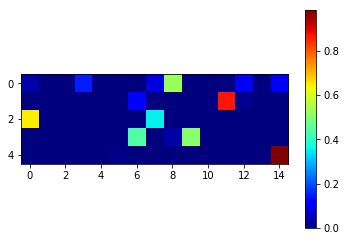

In [203]:
import matplotlib.pyplot as plt

x_final = x_fin["x"]
G_final = np.reshape(x_final[:z*a], (z, a))
for i in range(np.shape(G_final)[0]):
    G_final[i, :] = np.array(vec2simplex(G_final[i, :]))
W_final = np.reshape(x_final[z*a:], z)

plt.imshow(G_final, cmap='jet')
plt.colorbar()

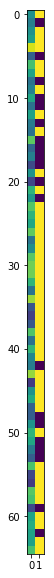

In [208]:
g_test = np.matmul(G_final, CNN_out)
y_predicted = np.tanh(np.matmul(W_final, g_test))

viz = np.concatenate((y_predicted, y_train), axis=1)

plt.figure(figsize=(1, 10))
plt.imshow(viz)


#print(y_predicted) # final predictions given a constant CNN output of attributes



